## Introduction

I'm very happy I could contribute with many exciting changes to
[Bambi](https://bambinos.github.io/bambi). Some changes, such as the
reorganization of the default priors and built-in families, are not visible to
the user but make the codebase more modular and easier to read. Other changes,
such as the ones I'm going to describe here, have a direct impact on what you
can do with Bambi.

Today I'll describe two new built-in families that have been added to Bambi.
The first one, already described in my previous post, is the `"t"` family. This
can be used to make linear regressions more robust to outliers. The second one the
`"beta"` family which can be used to model ratings and proportions.


In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Robust linear regression with the `t` family.


A Bayesian robust linear regression looks as follows

$$
y_i \sim \text{StudentT}(\mu_i, \lambda, \nu)
$$

where $\mu_i = \beta_0 + \beta_1 x_{1, i} + \cdots + \beta_p x_{p, i}$, $\lambda$ is
the precision parameter and $\nu$ is the degrees of freedom.

This wouldn't be a Bayesian model without priors. Bambi uses the following
priors by default:

$$
\begin{array}{c}
\beta_0 \sim \text{Normal}(\mu_{\beta_0}, \sigma_{\beta_0}) \\
\beta_j \sim \text{Normal}(\mu_{\beta_j}, \sigma_{\beta_j})  \\
\lambda \sim \text{HalfCauchy(1)}
\end{array}
$$

where the  $\mu_{\beta_j}$ and $\sigma_{\beta_j}$ are estimated from the data.
By default, $\nu=2$, but it is also possible to assign it a probability 
distribution (as we're going to see below).

Before seeing how this new family works, let's simulate some data. On this
opportunity, we're using the same dataset than in the [previous post](https://tcapretto.netlify.app/post/2021-07-05-robust-linear-regression-with-bambi/).
This is a toy dataset with one predictor `x`, one response `y`,
and some outliers contaminating the beautiful linear relationship between the
variables.

In [2]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
y = true_intercept + true_slope * x + np.random.normal(scale=0.5, size=size)

x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame(dict(x = x_out, y = y_out))

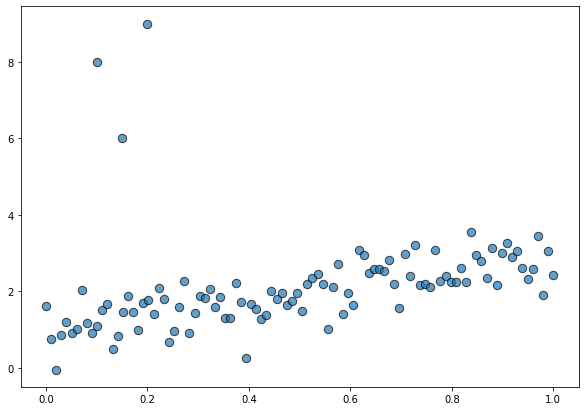

In [3]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(data["x"], data["y"], s=70, ec="black", alpha=0.7);

### Model specification and fit


Using this new family is extremely easy. It is almost as simple as running a 
default normal linear regression. The only difference is that we need to add 
the `family="t"` argument to the `Model()` instantiation.

In [4]:
model = bmb.Model("y ~ x", data, family="t")
model

Formula: y ~ x
Family name: T
Link: identity
Observations: 103
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 2.1234, sigma: 5.9491)
    x ~ Normal(mu: 0.0, sigma: 10.4201)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.2227)
    nu ~ Gamma(alpha: 2, beta: 0.1)

The output above shows information about the family being used and the parameters
for the default priors. Next, we just do `model.fit()` to run the sampler.

In [5]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_nu, y_sigma, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


### Use custom priors

Let's say we are not happy with having a fixed value for the degrees of freedom
and we want to assign it a prior distribution. Is that a problem? Of course not!

In [6]:
# Use a Gamma prior for the degrees of freedom
model = bmb.Model("y ~ x", data, family="t")
model.set_priors({"nu": bmb.Prior("Gamma", alpha=3, beta=1)})
model

Formula: y ~ x
Family name: T
Link: identity
Observations: 103
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 2.1234, sigma: 5.9491)
    x ~ Normal(mu: 0.0, sigma: 10.4201)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.2227)
    nu ~ Gamma(alpha: 3, beta: 1)

And hit the inference button

In [7]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_nu, y_sigma, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


### Explore results

First of all we can see the marginal posteriors for the parameters in the model and their respective traces

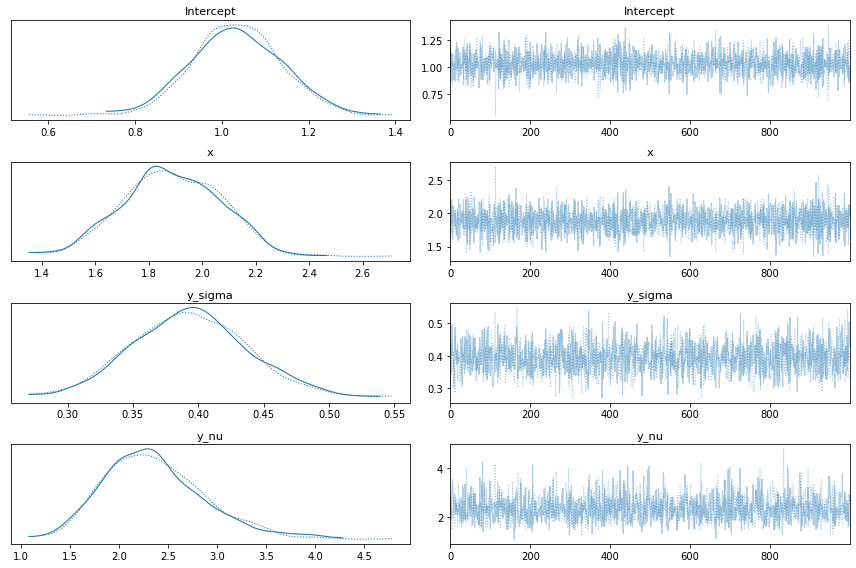

In [8]:
az.plot_trace(idata)
plt.tight_layout()

And it is also good to explore the posterior distribution of regression lines

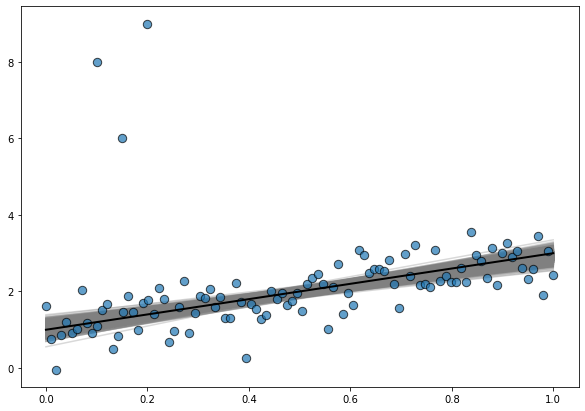

In [9]:
# Prepare data
x = np.linspace(0, 1, num=200)
posterior_stacked = idata.posterior.stack(samples=("chain", "draw"))
intercepts = posterior_stacked["Intercept"].values
slopes = posterior_stacked["x"].values

# Create plot
fig, ax = plt.subplots(figsize=(10, 7))

# Data points
ax.scatter(data["x"], data["y"], s=70, ec="black", alpha=0.7)

# Posterior regression lines
for a, b in zip(intercepts, slopes):
    ax.plot(x, a + b * x, color ="0.5", alpha=0.3, zorder=-1)

# True regression line
ax.plot(x, true_intercept + true_slope * x, color="k", lw=2);

where the line in black is the true regression line.

## Beta regression with the `beta` family.


Beta regression is useful to model response variables that have values within
the $(0, 1)$ interval. This type of regression is based on the assumption that 
the conditional distribution of the response variable follows a Beta distribution
with its mean related to a set of regressors through a linear predictor with 
unknown coefficients and a link function.

The beta regression model is based on an alternative parameterization of the 
beta density in terms of the mean $\mu$ and a precision parameter $\kappa$.

$$
\begin{array}{lr}
\displaystyle f(y | \mu, \kappa) = 
  \frac{\Gamma(\kappa)}{\Gamma(\mu\kappa)\Gamma((1-\mu)\kappa)} 
  y^{\mu\kappa -1}
  y^{(1 - \mu)\kappa -1}, & 0 < y < 1
\end{array}
$$

with $0 < \mu < 1$ and $\kappa > 0$.

If we use the same notation than for the robust linear regression, 
the beta regression model is defined as 

$$
y_i \sim \text{Beta}(g^{-1}(\mu_i), \kappa)
$$

where $\mu_i = \beta_0 + \beta_1 x_{1,i} + \cdots + \beta_p x_{p,i}$, $\kappa$ is
the precision parameter and $g$ is a twice differentiable, strictly increasing, 
link function.

Bambi uses again the following priors by default:

$$
\begin{array}{c}
\beta_0 \sim \text{Normal}(\mu_{\beta_0}, \sigma_{\beta_0}) \\
\beta_j \sim \text{Normal}(\mu_{\beta_j}, \sigma_{\beta_j})  \\
\kappa \sim \text{HalfCauchy(1)}
\end{array}
$$

where the  $\mu_{\beta_j}$ and $\sigma_{\beta_j}$ are estimated from the data.
By default, $g$ is the logit function. Other options available are the identity,
the probit, and the cloglog link functions.

It's possible to resume all of this in a very simplistic way by seeing that 
the beta regression as a very close relative of the GLM family. 
This model presents all the characteristics of GLMs, with the exception that the
beta distribution doesn't belong to the exponential family.

### Model specification and fit

Here we are going to use the `GasolineYield` dataset from the `betareg` R package.
This dataset is about the proportion of crude oil converted to gasoline. 
The response variable is the proportion of crude oil after distillation and 
fractionation. In this example, we use the temperature at which gasoline has 
vaporized in Fahrenheit degrees (`"temp"`) and a factor that indicates ten unique 
combinations of gravity, pressure and temperature (`"batch"`).

The following is just a re-ordering of the categories in the `"batch"` variable
so it matches the original contrasts used in the `betareg` package.

In [10]:
data = pd.read_csv("data/gasoline.csv")
data["batch"] = pd.Categorical(
  data["batch"], 
  [10, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
  ordered=True
)

Next, we define the model. The only difference is that we indicate `family="beta"`. Bambi handles all the rest for us.

In [11]:
# Note this model does not include an intercept
model = bmb.Model("yield ~ 0 + temp + batch", data, family="beta")
model

Formula: yield ~ 0 + temp + batch
Family name: Beta
Link: logit
Observations: 32
Priors:
  Common-level effects
    temp ~ Normal(mu: 0.0, sigma: 0.0364)
    batch ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [ 8.5769  7.5593  8.5769  8.5769  7.5593  8.5769  8.5769  7.5593  8.5769
 10.328 ])

  Auxiliary parameters
    kappa ~ HalfCauchy(beta: 1)

And `model.fit()` is all we need to ask the sampler to start running.

In [12]:
idata = model.fit(draws=2000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [yield_kappa, batch, temp]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.


### Explore results

Once we got the posterior, we explore it. This time we're going to plot highest density intervals for the marginal posteriors corresponding to the  parameters in the model.

In [13]:
summary = az.summary(idata, kind="stats")
summary

,mean,sd,hdi_3%,hdi_97%
temp,0.011,0.001,0.010,0.012
batch[10],-6.111,0.244,-6.586,-5.656
batch[1],-4.388,0.201,-4.766,-4.010
batch[2],-4.799,0.191,-5.167,-4.453
batch[3],-4.551,0.185,-4.892,-4.207
batch[4],-5.055,0.211,-5.442,-4.635
batch[5],-4.980,0.213,-5.415,-4.591
batch[6],-5.073,0.215,-5.468,-4.668
batch[7],-5.571,0.212,-5.973,-5.170
batch[8],-5.617,0.233,-6.030,-5.149


In [14]:
summary["row"] = list(range(12))
summary["panel"] = ["1-Temperature"] + ["2-Batch"] * 10 + ["3-Precision"]

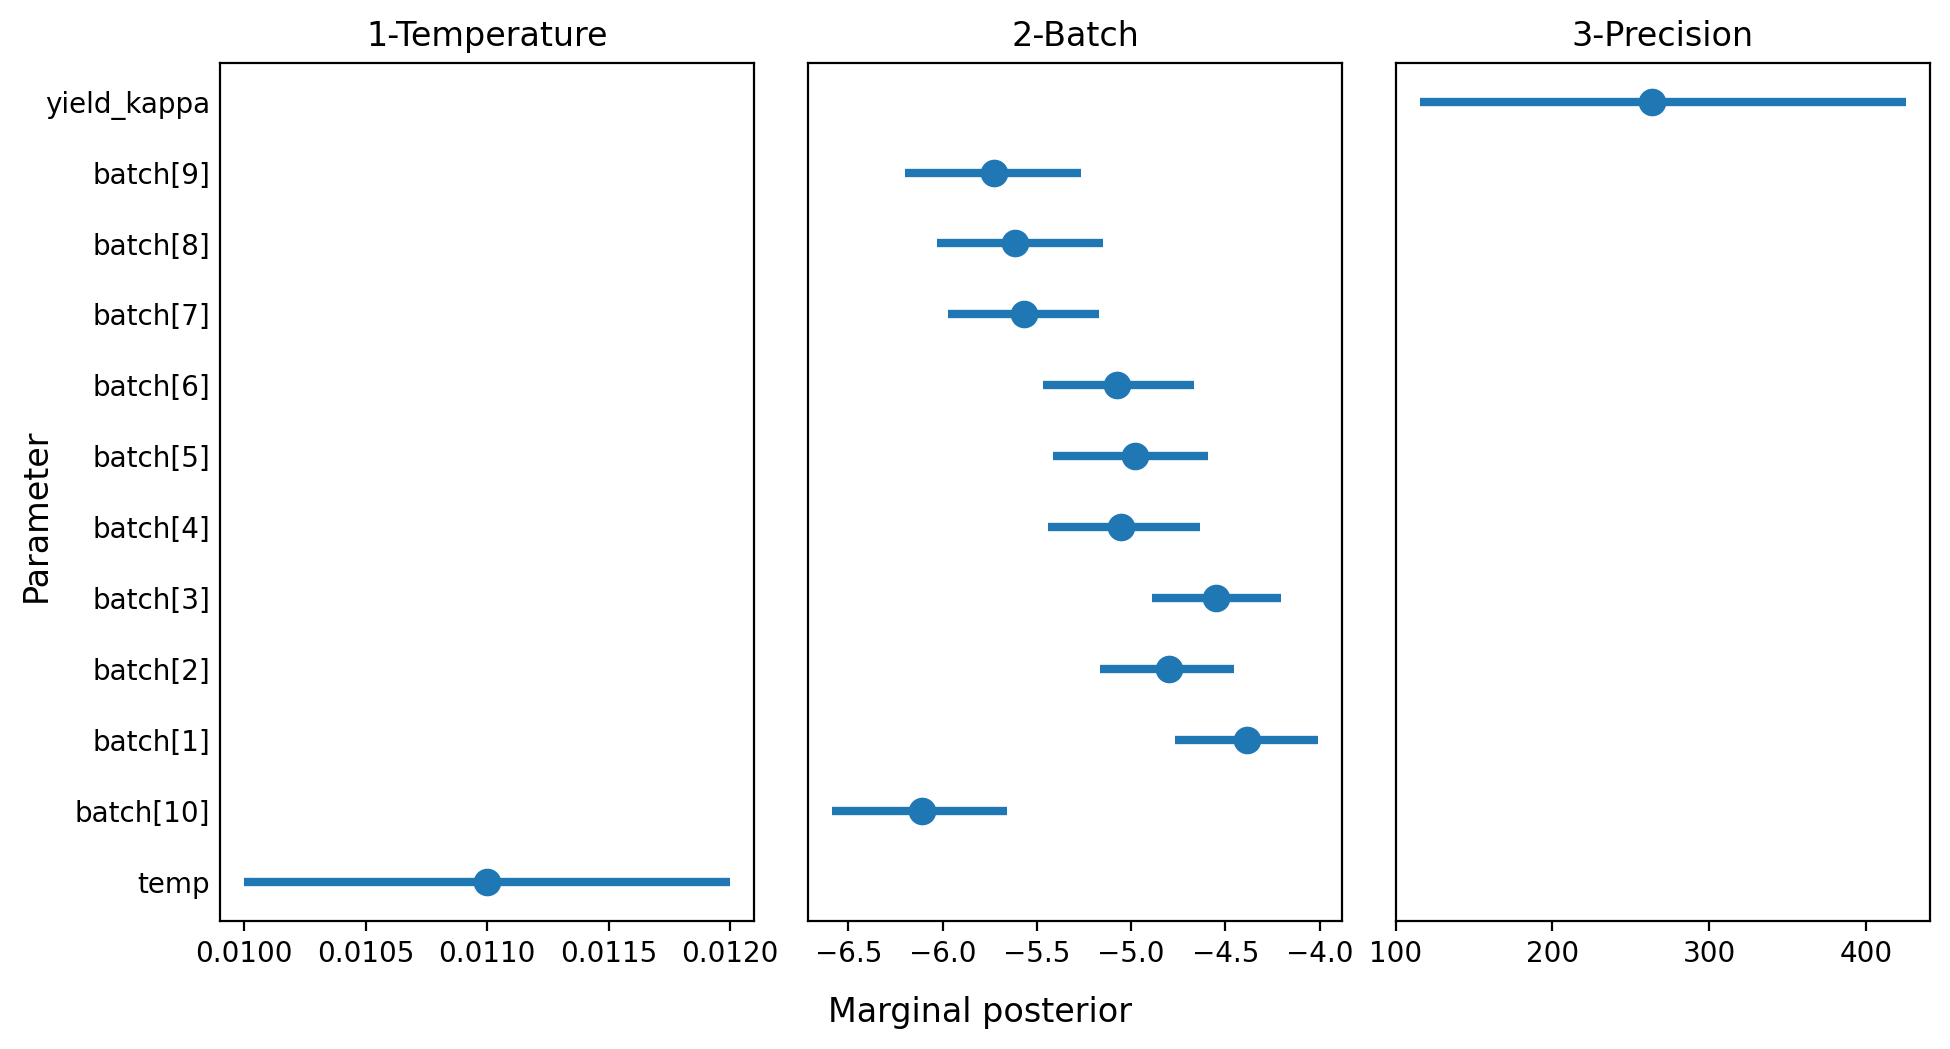

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5.33), sharey=True, dpi=200)
fig.subplots_adjust(left=0.12, right=0.975, wspace=0.1, bottom=0.12, top=0.925)
fig.set_facecolor("w")

for i, (ax, panel) in enumerate(zip(axes, ["1-Temperature", "2-Batch", "3-Precision"])):
    plt_data = summary[summary["panel"] == panel]
    ax.scatter(plt_data["mean"], plt_data["row"], s=80)
    ax.hlines(plt_data["row"], plt_data["hdi_3%"], plt_data["hdi_97%"], lw=3)
    ax.set_title(panel)
    ax.tick_params("y", length=0)

ax.set_yticks(range(len(summary.index)))
ax.set_yticklabels(list(summary.index))

fig.text(0.5, 0.025, "Marginal posterior", size=12, ha="center")
fig.text(0.02, 0.5, "Parameter", size=12, va="center", rotation=90)

fig.savefig("imgs/plot.png", dpi=200)